## Module Title:	 Data Visualization Techniques  & Machine Learning for Business 
### Assessment Title: Integrated CA
### Lecturer Name:	 David McQuaid  & PhD Muhammad Iqbal
### Student Full Name & Student ID:	Natalia de Oliveira Rodrigues 2023112

### GitHub Repository: 
https://github.com/norodrigues111/Recommendation-System-and-Market-Basket-Analysis.git

### Dataset Source:
https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba

## Introduction

This academic project aims to delivery a critical analysis of the knowledge produced, in the course: Higher Diploma in Science in Data Analytics for Business at CCT College.

In [1]:
#pip install plotly --upgrade

In [2]:
# Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import asarray
import statistics as stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from scipy.spatial.distance import cosine

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Groceries data.csv')

## Exploratory Data Analysis (EDA)

In [4]:
def glimpse(df):
    print(f'Observations: {df.shape[0]} rows \nAttributes: {df.shape[1]} columns')
    print("-" * 100)
    display(df.head())
    print("-" * 100)
    display(df.describe())
    print("-" * 100)
    display(f'Missing values: {df.isnull().sum().sum()}')
    print("-" * 100)
    display(df.info())
    
df = df
glimpse(df)

Observations: 38765 rows 
Attributes: 7 columns
----------------------------------------------------------------------------------------------------


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


----------------------------------------------------------------------------------------------------


,Member_number,year,month,day,day_of_week
count,38765.000000,38765.000000,38765.000000,38765.000000,38765.000000
mean,3003.641868,2014.528518,6.477570,15.753231,3.014498
std,1153.611031,0.499193,3.431561,8.801391,1.987669
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,4.000000,8.000000,1.000000
50%,3005.000000,2015.000000,6.000000,16.000000,3.000000
75%,4007.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


----------------------------------------------------------------------------------------------------


'Missing values: 0'

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


None

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Widget for selecting the time granularity
granularity_widget = widgets.Dropdown(
    options=['day', 'day_of_week', 'month', 'year'],
    value='day',
    description='Granularity:'
)

def plot_items_sold(df, granularity):
    # Create a new DataFrame with aggregated values based on the selected granularity
    if granularity == 'day':
        df_aggregated = df.groupby('Date').size().reset_index(name='Count')
    elif granularity == 'day_of_week':
        df_aggregated = df.groupby('day_of_week').size().reset_index(name='Count')
    elif granularity == 'month':
        df_aggregated = df.groupby('month').size().reset_index(name='Count')
    elif granularity == 'year':
        df_aggregated = df.groupby('year').size().reset_index(name='Count')

    # Plot using Plotly for interactive plots
    x_column = 'Date' if granularity == 'day' else granularity  # Correct x-column based on granularity

    if granularity in ['day', 'day_of_week', 'month']:
        fig = px.line(df_aggregated, x=x_column, y='Count', title=f'Items Sold - {granularity.capitalize()}ly')
    elif granularity in ['year']:
        fig = px.bar(df_aggregated, x=x_column, y='Count', title=f'Items Sold - {granularity.capitalize()}ly')

    fig.update_xaxes(title_text='Time')
    fig.update_yaxes(title_text='Number of Items Sold')

    # Display interactive plot
    fig.show()

# Interactive plot with widgets
@interact(granularity=granularity_widget)
def interactive_plot(granularity):
    plot_items_sold(df, granularity)

interactive(children=(Dropdown(description='Granularity:', options=('day', 'day_of_week', 'month', 'year'), va…

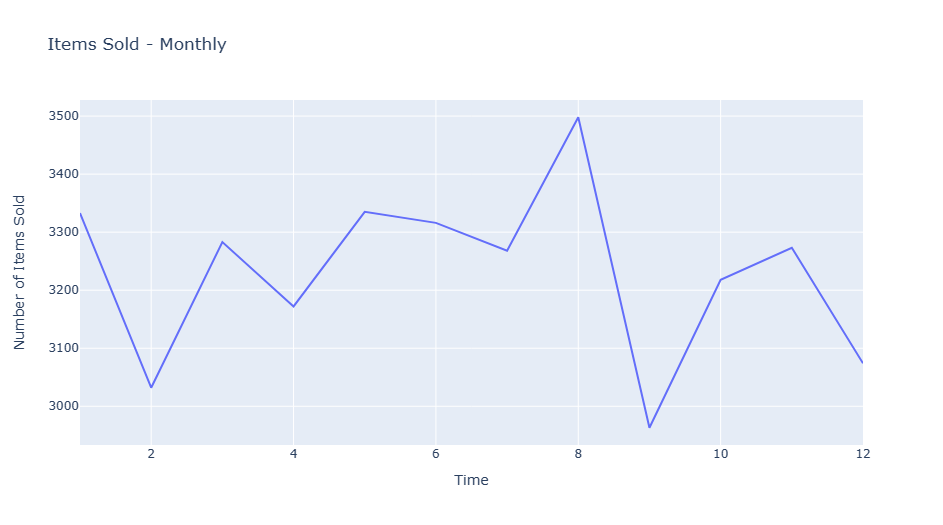

In [7]:
# Widget for selecting the year
year_widget = widgets.Dropdown(
    options=['2014', '2015', 'All'],
    value='All',
    description='Year:'
)

def plot_top_items(df, year):
    # Filter data based on the selected year
    if year == 'All':
        df_filtered = df
    else:
        df_filtered = df[df['year'] == int(year)]

    # Group by itemDescription and calculate the sum of sales
    top_items = df_filtered.groupby('itemDescription').size().reset_index(name='Count')
    
    # Sort in descending order
    top_items = top_items.sort_values(by='Count', ascending=False).head(10)

    # Reverse the order of bars
    top_items = top_items[::-1]

    # Plot using Plotly for interactive horizontal bar chart
    fig = px.bar(
        top_items,
        x='Count',
        y='itemDescription',
        orientation='h',
        title=f'Top 10 Items Sold - {year}' if year != 'All' else 'Top 10 Items Sold - All Period'
    )
    fig.update_xaxes(title_text='Number of Items Sold')
    fig.update_yaxes(title_text='Item Description')

    # Display interactive plot
    fig.show()

# Interactive plot with widgets
@interact(year=year_widget)
def interactive_top_items(year):
    plot_top_items(df, year)

interactive(children=(Dropdown(description='Year:', index=2, options=('2014', '2015', 'All'), value='All'), Ou…

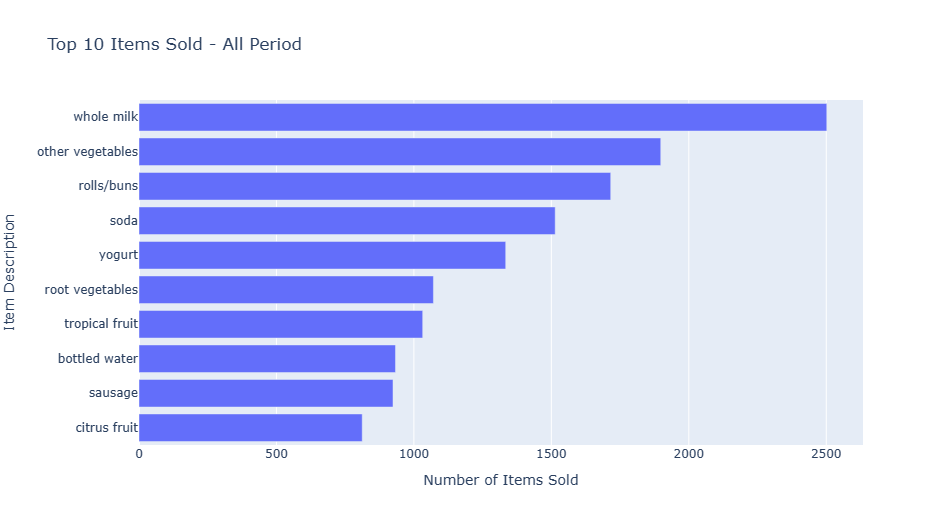

## 1.1 Discuss and explain the purpose of a recommendation system for online retail business in machine learning. 

According to (Wikipedia Contributors, 2019), online retail, also well known as eCommerce, allows customers to buy goods or services using web-based technology. Electronic Commerce permit businesses all over the world, the opportunity to collect customers' data. Technology makes it possible to build customers’ profiles based on demographic data, purchase history, preferences, and active data such as likes, views, clicks, and time spent. 

According to the research (Bertens, Guitart and Chen Andáfrica Periáñez, 2018), E-commerce frequently uses recommendation systems, which are typically implemented using cooperative filtering techniques. Based on user ratings, they compare comparable products or users.

AI has helped businesses to build powerful analytics tools to improve customer satisfaction and drive revenue. Recommendation Systems enable businesses to learn about their customers and provide more meaningful content, increasing customer satisfaction, and driving business revenue (Nawrocka, Kot and Nawrocki, 2018).
Industry leaders in online retail are using recommendation systems. According to (Arkadiusz, 2021), Amazon’s recommendations are responsible for 35% of revenue, and Netflix’s recommendations are responsible for 80% of the movies seen on the platform. In 2023, according to (Cooper and McLachlan, 2023), 70% of the videos watched on YouTube were recommended to their customers.

Recommendation engines enable customers to find goods or services using different algorithms. They are Contant-based filtering, based on item features and user profile data; Collaborative-based filtering, based on the similarity with other users (user-to-user or item-to-item); and Hybrid systems that combine Contant-based filtering, and Collaborative-based filtering. 


## Contant Filtering

In [8]:
rs_df = df.copy()

In [9]:
rs_df['Quantity'] = 1

In [12]:
# Replace NaN with an empty string
rs_df['itemDescription'] = rs_df['itemDescription'].fillna('')

In [13]:
rs_df.head(3)

,Member_number,Date,itemDescription,year,month,day,day_of_week,Quantity
0,1808,2015-07-21,tropical fruit,2015,7,21,1,1
1,2552,2015-05-01,whole milk,2015,5,1,4,1
2,2300,2015-09-19,pip fruit,2015,9,19,5,1
3,1187,2015-12-12,other vegetables,2015,12,12,5,1
4,3037,2015-01-02,whole milk,2015,1,2,4,1
...,...,...,...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,2014,8,10,6,1
38761,2022,2014-02-23,candy,2014,2,23,6,1
38762,1097,2014-04-16,cake bar,2014,4,16,2,1
38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2,1


In [14]:
rs_df.head()['itemDescription']

0      tropical fruit
1          whole milk
2           pip fruit
3    other vegetables
4          whole milk
Name: itemDescription, dtype: object

In [15]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
rs_df['itemDescription'] = rs_df['itemDescription'].fillna('')

In [16]:
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(rs_df['itemDescription'])

In [17]:
# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [18]:
sig[9]

array([0.76294559, 0.76159416, 0.7618768 , ..., 0.76159416, 0.76177271,
       0.76159416])

In [19]:
# Reverse mapping of indices and items names
indices = pd.Series(rs_df.index, index=rs_df['itemDescription']).drop_duplicates()

In [20]:
indices

itemDescription
tropical fruit               0
whole milk                   1
pip fruit                    2
other vegetables             3
whole milk                   4
                         ...  
sliced cheese            38760
candy                    38761
cake bar                 38762
fruit/vegetable juice    38763
cat food                 38764
Length: 38765, dtype: int64

In [21]:
indices['whole milk']

itemDescription
whole milk        1
whole milk        4
whole milk        8
whole milk       21
whole milk       53
              ...  
whole milk    38667
whole milk    38672
whole milk    38688
whole milk    38689
whole milk    38745
Length: 2502, dtype: int64

In [22]:
n_idx = indices['whole milk']

In [23]:
sig[n_idx]

array([[0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416]])

In [24]:
list(enumerate(sig[indices['whole milk']]))

[(0,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (1,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (2,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (3,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (4,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (5,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (6,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (7,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (8,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (9,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.7615

In [25]:
def give_rec(itemDescription, sig=sig):
    # Get the index corresponding to items
    idx = indices[itemDescription].iloc[0]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the items 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar items
    sig_scores = sig_scores[1:11]

    # item indices
    item_indices = [i[0] for i in sig_scores]

    # Top 10 most similar items
    return rs_df['itemDescription'].iloc[item_indices]

In [26]:
# Testing our content-based recommendation system with the seminal film Spy Kids
give_rec('whole milk')

4      whole milk
8      whole milk
21     whole milk
53     whole milk
54     whole milk
64     whole milk
70     whole milk
72     whole milk
97     whole milk
106    whole milk
Name: itemDescription, dtype: object

## Collaborative Filtering

In [27]:
# Pivot the DataFrame from long to wide format
user_item_matrix = rs_df.pivot_table(index='Member_number', columns='itemDescription', values='Quantity', aggfunc='sum', fill_value=0)

In [28]:
user_item_matrix.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [29]:
user_item_matrix.loc[1000,:]

itemDescription
Instant food products    0
UHT-milk                 0
abrasive cleaner         0
artif. sweetener         0
baby cosmetics           0
                        ..
white bread              0
white wine               0
whole milk               2
yogurt                   1
zwieback                 0
Name: 1000, Length: 167, dtype: int64

In [30]:
#Drop the Person column
data_cf = user_item_matrix.copy()

In [31]:
data_cf.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [32]:
data_cf = data_cf.reset_index()
data_cf.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1,1001,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,2,0,0
2,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [33]:
#Drop the member number column
data_cf = data_cf.drop("Member_number", axis=1)
data_cf.tail()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
3893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3896,0,0,0,0,0,0,0,0,0,2,...,0,0,0,1,0,0,0,0,1,0
3897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Create a placeholder dataframe listing item vs. item
data_icf = pd.DataFrame(index=data_cf.columns,columns=data_cf.columns)

data_icf.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
itemDescription,,,,,,,,,,,,,,,,,,,,,
Instant food products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UHT-milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abrasive cleaner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artif. sweetener,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baby cosmetics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
for i in range(0,len(data_icf.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(data_icf.columns)) :
      # Fill in placeholder with cosine similarities
      data_icf.iloc[i,j] = 1-cosine(data_cf.iloc[:,i],data_cf.iloc[:,j])

In [36]:
data_sims1 = user_item_matrix.reset_index()

In [37]:
data_sims1.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1,1001,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,2,0,0
2,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [38]:
# Create a place holder matrix for similarities, and fill in the user name column
data_sims = pd.DataFrame(index=data_sims1.index,columns=data_sims1.columns)
data_sims.iloc[:,:1] = data_sims1.iloc[:,:1]

In [39]:
# This is the same as our original data but with nothing filled in except the headers
data_sims.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_neighbours = pd.DataFrame(index=data_icf.columns,columns=range(1,7))
 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(data_icf.columns)):
    data_neighbours.iloc[i,:11] = data_icf.iloc[0:,i].sort_values(ascending=False)[:11].index

In [41]:
# Print a sample
data_neighbours.iloc[:,1:11]

,2,3,4,5,6
itemDescription,,,,,
Instant food products,root vegetables,margarine,soda,whole milk,chocolate
UHT-milk,other vegetables,whole milk,rolls/buns,soda,tropical fruit
abrasive cleaner,frozen potato products,meat spreads,spread cheese,sausage,other vegetables
artif. sweetener,baby cosmetics,make up remover,bottled water,whole milk,instant coffee
baby cosmetics,skin care,artif. sweetener,oil,frankfurter,frozen dessert
...,...,...,...,...,...
white bread,whole milk,rolls/buns,other vegetables,soda,whipped/sour cream
white wine,whole milk,soda,sausage,yogurt,rolls/buns
whole milk,other vegetables,rolls/buns,yogurt,soda,tropical fruit


In [42]:
# Specify the index you want to retrieve attributes for
selected_index = 'whole milk'

# Get the list of 5 attributes for the specified index
attributes_list = data_neighbours.loc[selected_index] #.tolist()

# Print the result
print(f"Attributes for '{selected_index}':")
attributes_list[1:11]

Attributes for 'whole milk':


2    other vegetables
3          rolls/buns
4              yogurt
5                soda
6      tropical fruit
Name: whole milk, dtype: object

## 1.2)	Briefly compare Content and Collaborative filtering using any dataset of your choice. Train and test machine learning models for the user-user or item-item collaborative filtering. 

### Content Filtering Vs Collaborative Filtering:

According to (Shivam, 2022), Content Filtering, recommends items based on the content similarity of items. It relies on the items’ characteristics. While Collaborative Filtering, recommends items based on user-item interactions, finding items that are similar in terms of user preferences. It is well known, that the choice between content-based and collaborative filtering depends on the specific use case and the available data.

For Content Filtering, TF-IDF (Term Frequency-Inverse Document Frequency) and sigmoid kernel for similarity computation were used as a method. In this paper, content filtering fails to recommend similar items based on the users’ preferences. All results from the recommendation list are like the given item. The chosen dataset does not bring information regarding items, only the names. The paper evaluates that the dataset is not suitable for content filtering, once it relies too much on item features.

For Collaborative Filtering, the cosine similarity method was used to build a user-item matrix between columns. Given an item 'whole milk', collaborative filtering recommends similar items based on the preferences of users who liked 'whole milk.' The similarity is calculated using the user-item interaction matrix. The results show the top 5 items that are most like 'whole milk' include 'other vegetables,' 'rolls/buns,' 'yogurt,' 'soda,' and 'tropical fruit.' It is successfully capturing personalized recommendations.


## 1.3)	Justify your recommendations for the considered scenario by providing a conceptual insight. 

In conclusion, in the contant filtering results, it seems like the system is recommending the same item ('whole milk') rather than similar items. This is because the content-based filtering approach is designed to recommend items that are similar in content to the given item, and in this case, 'whole milk' is considered most like itself.

Given that, this paper recommends the use of Collaborative Filtering. It is effective in capturing personalized recommendations. Collaborative filtering is recommending items that are frequently co-purchased or interacted with by users who have also interacted with 'whole milk'. So, in collaborative filtering, you see a list of items that tend to be chosen by users who have chosen 'whole milk', and these items are different from 'whole milk' itself.


## 2.1) Perform Market Basket Analysis on the chosen dataset by using Apriori and FP growth algorithms.

## Market Basket Analysis

In retail organizations, market basket analysis is a crucial part of analytical CRM. Finding correlations or co-occurrences from transactional data through analysis can enable you to offer related products together, increasing revenue in the process. Many businesses have heavily relied on market basket analysis to identify product linkages and inform retailer promotion strategies (Charlet and Kumar, 2012). 

According to (Manpreet and Shivani, 2016), affinity analysis or association rule learning are other names for market basket analysis (MBA). In the retail industry, it gives retailers the knowledge they need to comprehend customer purchasing patterns and make informed decisions.


In [43]:
mba_df = pd.read_csv('basket.csv')

In [44]:
mba_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Transpose the DataFrame
df_transposed = mba_df.transpose()

# Convert each row to a list of items, ensuring all items are strings
transactions = df_transposed.apply(lambda row: [str(item) for item in row.dropna()], axis=1).tolist()

# Convert the list of lists into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [46]:
# Apriori Algorithm
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.8, use_colnames=True, max_len=3)

# Apriori Association Rules
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.8)

In [47]:
print("\nApriori Association Rules:")
rules_apriori_table = rules_apriori[['antecedents', 'consequents', 'antecedent support', 'consequent support',
                                     'support', 'confidence', 'lift', 'leverage', 'conviction', 'zhangs_metric']]

rules_apriori_table.sort_values(by='confidence', ascending=False).drop_duplicates(subset='antecedents').head(10)


Apriori Association Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(canned beer),(butter),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6404,"(sugar, hard cheese)",(frozen vegetables),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6406,(sugar),"(frozen vegetables, hard cheese)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6407,(hard cheese),"(frozen vegetables, sugar)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6408,"(frozen vegetables, hard cheese)",(whipped/sour cream),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6409,"(frozen vegetables, whipped/sour cream)",(hard cheese),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6410,"(whipped/sour cream, hard cheese)",(frozen vegetables),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6411,(frozen vegetables),"(whipped/sour cream, hard cheese)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6413,(whipped/sour cream),"(frozen vegetables, hard cheese)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6414,"(white bread, frozen vegetables)",(hard cheese),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0


In [48]:
# FP-Growth Algorithm
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.8, use_colnames=True, max_len=3) 

# FP-Growth Association Rules
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.8)

In [49]:
rules_fpgrowth_table = rules_fpgrowth[['antecedents', 'consequents', 'antecedent support', 'consequent support',
                                       'support', 'confidence', 'lift', 'leverage', 'conviction', 'zhangs_metric']]
print("\nFP-Growth Association Rules:")
rules_fpgrowth_table.sort_values(by='confidence', ascending=False).drop_duplicates(subset='antecedents').head(10)


FP-Growth Association Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(whole milk),(newspapers),0.818182,0.909091,0.818182,1.0,1.100000,0.07438,inf,0.5
6435,"(hygiene articles, rolls/buns)",(sugar),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6437,(hygiene articles),"(rolls/buns, sugar)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6438,(sugar),"(hygiene articles, rolls/buns)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6439,(rolls/buns),"(hygiene articles, sugar)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6440,"(rolls/buns, sugar)",(hard cheese),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6441,"(rolls/buns, hard cheese)",(sugar),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6442,"(sugar, hard cheese)",(rolls/buns),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6445,(hard cheese),"(rolls/buns, sugar)",0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0
6446,"(rolls/buns, frozen vegetables)",(sugar),0.818182,0.818182,0.818182,1.0,1.222222,0.14876,inf,1.0


## 2.2) Can you express the major divergence between these models? Compare and contrast the machine learning results obtained based on both algorithms. 

### The major divergence between models:

Machine Learning Models Apriori and FP-Growth have the same main objective of identifying frequent itemsets in transaction datasets. Both approaches are to find patterns in the data, revealing important patterns in the data, in machine learning outputs. Apriori and FP-Growth are machine learning algorithms used for Market Basket analysis, but they have different approaches. Apriori is a kind of candidate generation method, that scans candidate itemsets until finds the frequent ones. 

In contrast, FP-Growth uses the frequency pattern on the data to growth approach, creating a tree, that is called FP-Tree. The tree represents the dataset and efficiently mining in two passes. This distinction leads to significant divergences in efficiency. This distinction leads to significant divergences in efficiency. When working with large datasets and sparse data, Apriori necessitates numerous database scans, which increases computational costs and memory use. In contrast, FP-Growth reduces runtime, memory requirements, and scan times, which makes it a better option for association rule mining jobs.

### Comparison and contrast of the machine learning results:

In this Market Basket Analysis, as given before, the association rules are created from two different algorithms, Apriori and FP-Growth. The results show the revealed associations between items in data based on their support, confidence, lift, and other metrics. 

According to (Charlet and Kumar, 2012), frequent itemsets are used to generate association rules, with support and confidence serving as threshold values. The term "frequent itemset" refers to collections of items with the least amount of support. The percentage of transactions in the data set that contain an itemset is known as the itemset’s support. The degree of assurance or dependability connected to each pattern that is found is known as confidence. The generated association rules rely on confidence.

In the Apriori results, the rules reveal strong associations between items such as "canned beer" and "butter," "sugar" and "hard cheese," and various combinations of "frozen vegetables," "whipped/sour cream," and "hard cheese." 
On the other hand, the FP-Growth results show associations like "whole milk" and "newspapers," as well as patterns involving "hygiene articles," "rolls/buns," and "sugar." Like Apriori, the lift values are greater than 1, suggesting positive correlations.

For both algorithms, the lift values are consistently above 1, indicating positive associations. Lift is a metric that quantifies the degree to which the consequent is more likely than expected given the antecedent. A rule with a high lift indicates that buying the antecedent also greatly increases the likelihood of buying the consequent. A confidence of 0.8 means there is an 80% likelihood that the associated set of items. it measures the likelihood that the consequent item will be bought if the antecedent item is bought. The high confidence and lift indicate a strong association between the antecedent and the consequent.

In conclusion, it is crucial to note that, due to the algorithm’s methodologies, the specific associations and patterns discovered may vary. FP-Growth uses a frequent pattern growth strategy, while Apriori uses a candidate generation approach. FP-Growth shows to be more efficient, with quicker execution. Both algorithms reveal associations in the data, but the specific rules, efficiency of computation and memory usage are different from one to another. 


## 3.1) Create an interactive Dashboard aimed at older adults (65+) with specific features to summarise the most important aspects of the data and identify through your visualisation why this dataset is suitable for Machine Learning models in an online retail business. 

## 3.2) Explain how your dashboard is designed with this demographic in mind.

# References
- a
- b
- c